In [1]:
# 서울에 위치한 지하철역 자치구, 역명 데이터 수집
import pandas as pd

# 수도권 지하철 데이터 파일 경로 리스트
file_paths = [ '~/line1.csv', '~/line2.csv', '~/line3.csv', '~/line4.csv', '~/line5.csv',
               '~/line6.csv', '~/line7.csv', '~/line8.csv', '~/line9.csv', '~/linegy.csv',
               '~/linegch.csv', '~/linebd.csv', '~/linegh.csv' ]

# '서울'에 있는 지하철역명과 자치구명을 저장할 리스트
seoul_stat = []

# 각 파일에 대해 처리
for file_path in file_paths:
    line = pd.read_csv(file_path, encoding='cp949')
    
    # '서울'이 포함된 행 필터링
    filtered = line[line['지번주소'].str.contains('서울특별시', na=False)].copy()
    
    # '서울특별시' 뒤에 있는 자치구명 추출하여 '자치구명' 컬럼 추가
    filtered['자치구명'] = filtered['지번주소'].str.extract(r'서울특별시\s(\S+구)')
    
    # '역명'과 '자치구명'만 선택하여 리스트에 추가
    seoul_stat.append(filtered[['역명', '자치구명']])

# 데이터프레임들을 하나로 합치기
seoul_stat2 = pd.concat(seoul_stat, ignore_index=True)

# 컬럼명을 '전철역명'으로 변경
seoul_stat2.columns = ['전철역명', '자치구명']

# 중복된 '전철역명' 제거
seoul_stat2 = seoul_stat2.drop_duplicates(subset='전철역명')

# 결과 출력
seoul_stat2

,전철역명,자치구명
0,가산디지털단지,금천구
1,개봉,구로구
2,구로,구로구
3,금천구청,금천구
4,남영,용산구
...,...,...
342,구룡,강남구
344,복정(동서울대학),송파구
345,서울숲,성동구
348,압구정로데오,강남구


In [ ]:
# 지하철역명을 블로그에 검색한 결과 게시물 건수 수집

# 네이버 블로그 함수 생성
# 모듈 불러오기
import urllib.request
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time

# 게시물 건수를 가져오는 함수 생성
def naver_blog_count(keyword):
    try:
        # 키워드 검색
        text1 = urllib.parse.quote(keyword)
        # 크롬 드라이버 경로 지정 (본인의 경로로 수정)
        service = Service("/Users/dgriii0606/Desktop/chromedriver-mac-arm64/chromedriver")
        driver = webdriver.Chrome(service=service)

        # 검색 페이지 URL
        list_url = f"https://section.blog.naver.com/Search/Post.naver?rangeType=ALL&orderBy=sim&keyword={text1}"

        # 크롬 봇이 웹페이지를 직접 열 수 있게 함
        driver.get(list_url)
        time.sleep(3)  # 페이지 로딩 대기 시간을 3초로 늘림

        # 크롬 봇이 직접 연 웹페이지의 html 코드를 가져옴
        html = driver.page_source

        # html 코드를 BS로 파싱
        soup = BeautifulSoup(html, "lxml")  # html.parser 또는 lxml을 사용

        # 게시물 건수 추출 (em.search_number 클래스 사용)
        count_tag = soup.find("em", class_="search_number")
        if count_tag:
            count_text = count_tag.get_text(strip=True).replace(',', '')  # ',' 제거 후 숫자로 변환
            count_text = count_text.replace('건', '')  # '건' 제거
            count = int(count_text)
        else:
            count = 0  # 게시물이 없을 경우 0으로 처리
        
        driver.quit()  # 드라이버 종료
        return count
    
    except Exception as e:
        print(f"오류 발생: {e}")
        driver.quit()
        return 0

In [ ]:
# 함수에 수집한 지하철 키워드 입력하고 나온 게시물 건수 수집해서 데이터 프레임 생성
# 모듈 불러오기
import pandas as pd

# 각 지하철역 이름으로 검색하고 게시물 수 집계
results = []
for idx, row in seoul_stat2.iterrows():
    keyword = row['역명'] + '역'
    gu_name = row['자치구명']
    
    print(f"키워드 '{keyword}'로 검색 중...")
    post_count = naver_blog_count(keyword)  # 게시물 수 추출
    results.append({'자치구명': gu_name, '역명': row['역명'], '게시물_건수': post_count})  # 결과 저장
    print(f"'{keyword}'의 검색된 블로그 게시물 수: {post_count}건")

# 결과를 자치구명, 역명, 게시물 건수의 데이터프레임으로 생성
df_results = pd.DataFrame(results)

# 데이터프레임을 CSV 파일로 저장
df_results.to_csv('subway_blog_results.csv', index=False, encoding='utf-8-sig')

In [3]:
results = pd.read_csv('~/subway_blog_results.csv')
results

,자치구명,역명,게시물_건수
0,금천구,가산디지털단지,241222
1,구로구,개봉,69005
2,구로구,구로,101584
3,금천구,금천구청,56707
4,용산구,남영,73530
...,...,...,...
278,강남구,구룡,25192
279,송파구,복정(동서울대학),457
280,성동구,서울숲,323630
281,강남구,압구정로데오,309710


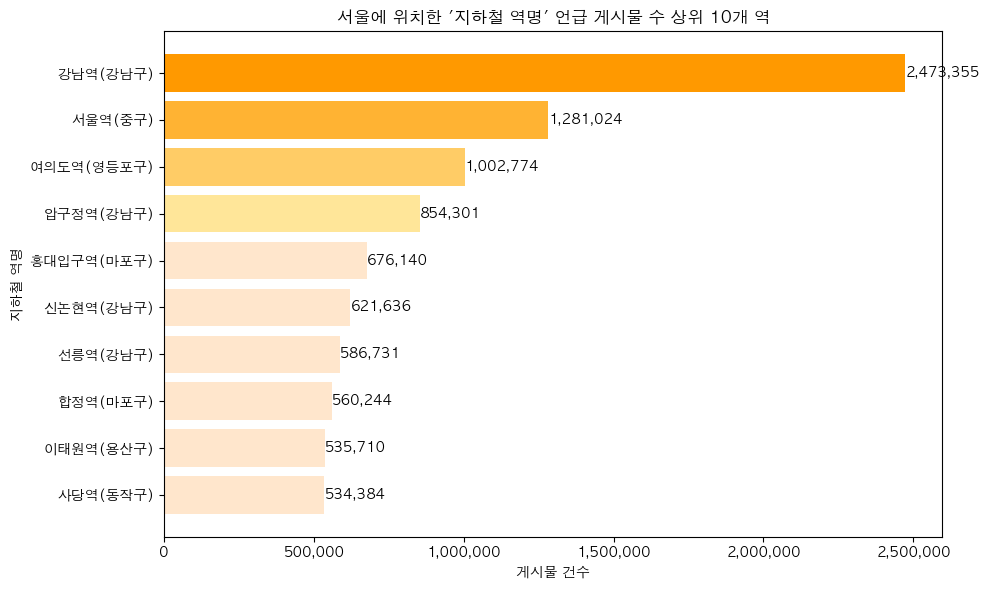

In [23]:
# 지하철역별 언급 게시물 수 상위 10개
# 데이터 불러오기
import pandas as pd
sub = pd.read_csv('~/subway_blog_results.csv')

substat1 = sub.sort_values(by='게시물_건수', ascending=False).head(10)
substat1['역명'] = substat1['역명'].apply(lambda x: x if x.endswith('역') else x + '역')
substat1

# Create new labels by combining '역명' and '자치구명'
substat1['역명_자치구'] = substat1['역명'] + '(' + substat1['자치구명'] + ')'

# 모듈 불러오기
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc # 한글 폰트 깨지지 않게하는 모듈
from matplotlib.colors import to_rgba

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 오렌지 색상 계열
base_color = to_rgba("orange")
color_levels = [
    (1, 0.6, 0, 1),    # Deep orange
    (1, 0.7, 0.2, 1),  # Slightly lighter
    (1, 0.8, 0.4, 1),  # Lighter
    (1, 0.9, 0.6, 1)   # Lightest for the top 4
]
lighter_color = (1, 0.9, 0.8, 1)  # Very light for the rest

# Assign colors based on the rankings (top 4 stations get different saturations, rest get lighter tone)
colors = [color_levels[i] if i < 4 else lighter_color for i in range(len(substat1))]

plt.figure(figsize=(10, 6))
bars = plt.barh(substat1['역명_자치구'], substat1['게시물_건수'], color=colors)

# Add text labels at the end of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{int(bar.get_width()):,}', va='center')

# Ensure full numbers are displayed on the x-axis with commas for thousands
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.xlabel('게시물 건수')
plt.ylabel('지하철 역명')
plt.title("서울에 위치한 '지하철 역명' 언급 게시물 수 상위 10개 역")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values on top
plt.tight_layout()

# Show the updated plot with commas for thousands on the x-axis
plt.savefig('blog1.png')

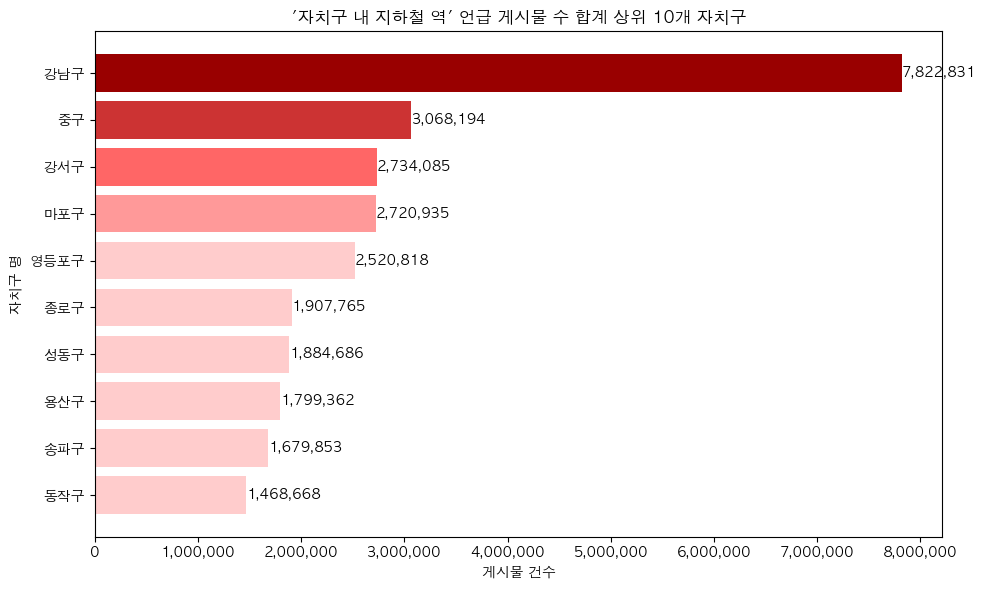

In [25]:
# '자치구 내 지하철 역' 언급 게시물 수 합계 상위 10개 자치구
# 데이터 불러오기
import pandas as pd
sub = pd.read_csv('~/subway_blog_results.csv')

subgu1 = sub.groupby('자치구명')['게시물_건수'].sum().reset_index()
subgu2 = subgu1.sort_values(by='게시물_건수', ascending=False).head(10)
subgu2

# 모듈 불러오기
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc # 한글 폰트 깨지지 않게하는 모듈
from matplotlib.colors import to_rgba

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 레드 계열 색상
base_color = to_rgba("red")
color_levels = [
    (0.6, 0, 0, 1),    # Deep red
    (0.8, 0.2, 0.2, 1),  # Slightly lighter red
    (1, 0.4, 0.4, 1),    # Lighter red
    (1, 0.6, 0.6, 1)     # Lightest red
]
lighter_color = (1, 0.8, 0.8, 1)  # Very light red for the rest

# 순위에 따라 색상이 할당 (상위 4개의 채도가 다르고 나머지 값의 톤은 같은 옅은 톤으로 통일)
colors = [color_levels[i] if i < 4 else lighter_color for i in range(len(subgu2))]

plt.figure(figsize=(10, 6))
bars = plt.barh(subgu2['자치구명'], subgu2['게시물_건수'], color=colors)

# Add text labels at the end of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{int(bar.get_width()):,}', va='center')

# Ensure full numbers are displayed on the x-axis with commas for thousands
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.xlabel('게시물 건수')
plt.ylabel('자치구 명')
plt.title("'자치구 내 지하철 역' 언급 게시물 수 합계 상위 10개 자치구")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values on top
plt.tight_layout()

# Show the updated plot with commas for thousands on the x-axis
plt.savefig('blog2.png')